### Attention of Softmax(20News)

In [1]:
import pandas as pd
import torch.utils.data as Data
import torch.optim as optim
from torch.autograd import Variable
import torch
import pickle
from torch import optim
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
filename = 'data/local_dict.pkl'
path = filename
dict_file = open(path, 'rb')

vocab  = pickle.load(dict_file)[0]
print('length of vocabulary: ',len(vocab))
dict_file.close()

filename = "data/Train.csv"
Train = pd.read_csv(filename)

length of vocabulary:  16174


In [3]:
vocab_size = 8000
text_length = 30
batch_size = 100
epoch_num = 100

word2idx = {'[PAD]':0}
for i, w in enumerate(vocab[:vocab_size]):
    word2idx[w] = i + 1
idx2word = {i: w for i, w in enumerate(word2idx)}

doc_list = Train['text'].to_list()
labels = Train['label'].astype('int').to_list()

In [4]:
from model import make_data
data = make_data(doc_list,word2idx,text_length)

In [5]:
len(data),len(labels)

(1353, 1353)

In [6]:
from model import MyDataSet

batch = Variable(torch.LongTensor(data))
labels = Variable(torch.LongTensor(labels))
loader = Data.DataLoader(MyDataSet(batch,labels), batch_size, True)

In [7]:
from model import SelfAttnClassifier

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

loss_function = nn.BCELoss()
model = SelfAttnClassifier(vocab_size+1, 200, 100, 1, scale=5.0,score_function='dot',activation='SoftMax')
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.05)

use_gpu = torch.cuda.is_available()

if(use_gpu):
    model = model.cuda()
    loss_function = loss_function.cuda()

In [8]:
model.train()
for epoch in tqdm(range(100)):
    for input_ids, label in loader:
        model.zero_grad()
        preds = model(input_ids.cuda())
        loss = loss_function(preds.squeeze(), label.cuda().float()) * 100
        loss.backward(retain_graph=True)
        optimizer.step()
        input_ids.cpu()
        label.cpu()

100%|██████████| 100/100 [00:13<00:00,  7.63it/s]


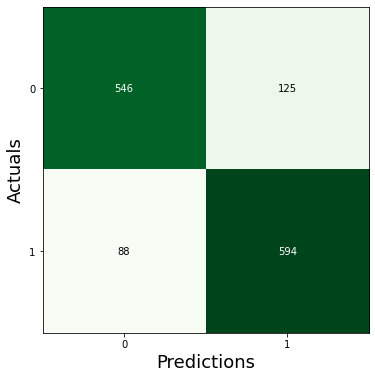

accuracy:84.257%


In [13]:
from model import plot_cm_matrix
plot_cm_matrix(model,batch,labels,save_url='graph/metric/SoftmaxTrainAcc.png')

### test accuracy

In [14]:
filename = "data/Test.csv"
Test = pd.read_csv(filename)

doc_list = Test['text'].to_list()
test_labels = Test['label'].astype('int').to_list()
    
test_data = make_data(doc_list,word2idx,text_length)
len(test_data),len(test_labels)

(580, 580)

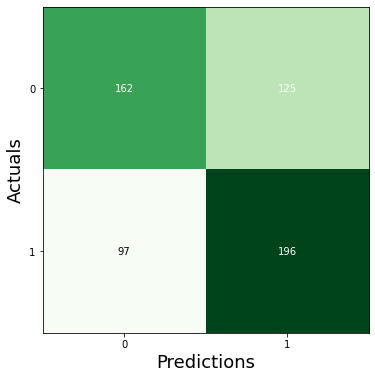

accuracy:61.724%


In [15]:
test_batch = Variable(torch.LongTensor(test_data))
test_labels = Variable(torch.LongTensor(test_labels))
plot_cm_matrix(model,test_batch,test_labels,save_url='graph/metric/picture3.png')

### Save Model

In [16]:
## 保存
torch.save(model.state_dict(), 'model/SoftmaxParameter.pkl')
torch.save(model, 'model/SoftmaxModel.pkl')

## 加载
#model = SelfAttnClassifier(vocab_size+1, 30, 10, 1, scale=5.0,score_function='dot',activation='SoftMax')
#model.load_state_dict(torch.load('model/SoftmaxParameter.pkl'))

# 加载
#model = torch.load('model/SoftmaxModel.pkl')

### Select Tokens

In [9]:
from model import SelectTokens
Pos,Neg,Neu = SelectTokens(data,labels,word2idx)

### Visualization

In [10]:
from model import compute_coefficients
pos_index,pos_score,pos_weight,neg_index,neg_score,neg_weight,neutral_index,neutral_score,neutral_weight = compute_coefficients(model,batch,Pos,Neg,Neu,word2idx)

Pos Mean: -0.4054892091169244 Pos Std: 0.47799117005036457
Neg Mean: -0.47129725460380095 Neg Std: 0.465216762407706
Neu Mean: -1.605701104696695 Neu Std: 0.6323125825646976


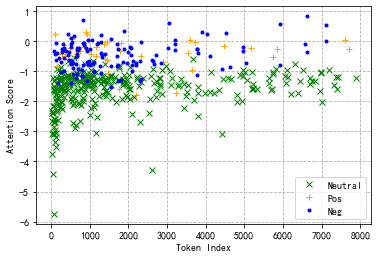

In [25]:
plt.rcParams['axes.unicode_minus'] = False
plt.plot(neutral_index, neutral_score, 'x', label='Neutral',color='green')
plt.plot(pos_index, pos_score, '+',label='Pos',color='orange')
plt.plot(neg_index, neg_score, '.', label='Neg',color='blue')
plt.xlabel('Token Index')
plt.ylabel('Attention Score')
plt.grid(linestyle='--')
plt.legend()
plt.savefig('graph/metric/picture1.png')
print('Pos Mean:',np.mean(pos_score),'Pos Std:',np.std(pos_score))
print('Neg Mean:',np.mean(neg_score),'Neg Std:',np.std(neg_score))
print('Neu Mean:',np.mean(neutral_score),'Neu Std:',np.std(neutral_score))

Pos Mean: 0.1437858968421293 Pos Std: 0.04967029210065616
Neg Mean: 0.13258897788298538 Neg Std: 0.054874829307033406
Neu Mean: 0.054478701412241363 Neu Std: 0.02868752744208355


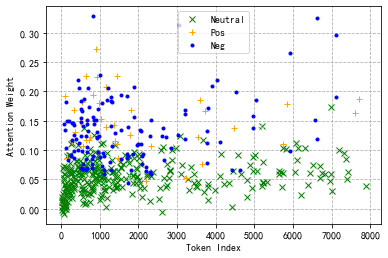

In [28]:
plt.rcParams['axes.unicode_minus'] = False
plt.plot(neutral_index,neutral_weight, 'x', label='Neutral',color='green')
plt.plot(pos_index, pos_weight, '+',label='Pos',color='orange')
plt.plot(neg_index, neg_weight, '.', label='Neg',color='blue')
plt.xlabel('Token Index')
plt.ylabel('Attention Weight')
plt.grid(linestyle='--')
plt.legend()
plt.savefig('graph/metric/picture2.png')
print('Pos Mean:',np.mean(pos_weight),'Pos Std:',np.std(pos_weight))
print('Neg Mean:',np.mean(neg_weight),'Neg Std:',np.std(neg_weight))
print('Neu Mean:',np.mean(neutral_weight),'Neu Std:',np.std(neutral_weight))

### Exp1--Feature Importance

580it [00:03, 170.25it/s]


Both label
	p-value < 0.05: 575  ratio: 1.0
	p-value < 0.01: 574  ratio: 0.9982608695652174
	Both-Mean: 0.7749684754764394 Std: 0.09548814318477464

Pos
	p-value < 0.05: 292  ratio: 1.0
	p-value < 0.01: 291  ratio: 0.9965753424657534
	Pos-Mean: 0.7771902474449002 Std: 0.10012215654178111

Neg
	p-value < 0.05: 283  ratio: 1.0
	p-value < 0.01: 283  ratio: 1.0
	Neg-Mean: 0.772676046448911 Std: 0.09040104473049435


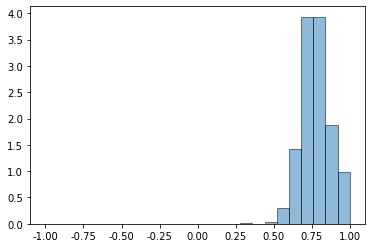

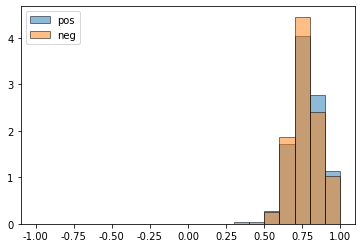

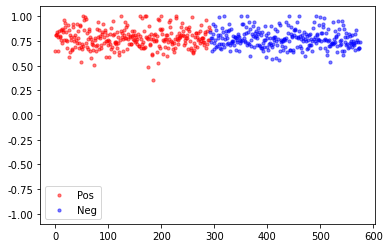

In [21]:
from model import GradientImportance
GradientImportance(model,test_batch,test_labels,'Softmax')

### Exp2--Feature Erasure

580it [00:09, 62.58it/s]


Both label
	p-value < 0.05: 204  ratio: 0.35478260869565215
	p-value < 0.01: 120  ratio: 0.20869565217391303
	total num: 575  mean: -0.005410902915349343  std: 0.29560321936530937
Pos
	p-value < 0.05: 107  ratio: 0.3664383561643836
	p-value < 0.01: 65  ratio: 0.2226027397260274
	total num: 292  mean: 0.10555238050267676  std: 0.29067617285238745
Neg
	p-value < 0.05: 97  ratio: 0.34275618374558303
	p-value < 0.01: 55  ratio: 0.19434628975265017
	total num: 283  mean: -0.11990305400391339  std: 0.2540647080740295


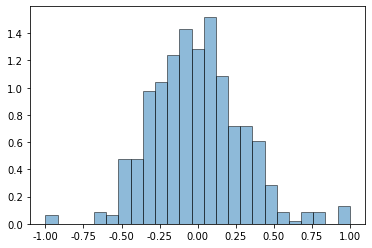

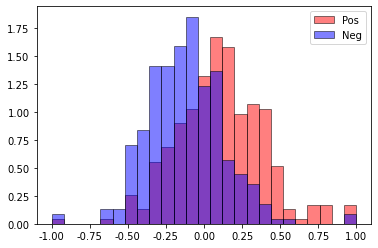

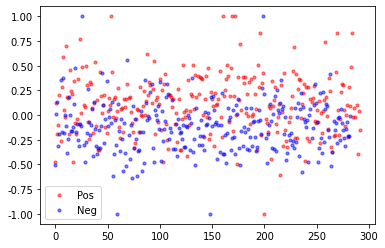

In [22]:
from model import FeatureErasure
FeatureErasure(model,test_batch,test_labels,'Softmax')

### Exp3--Feature Erasure ABS

580it [00:17, 33.32it/s]


Both label
	p-value < 0.05: 575  ratio: 1.0
	p-value < 0.01: 574  ratio: 0.9982608695652174
	total num: 575  mean: 0.8039292342177496  std: 0.08893806514237979
Pos
	p-value < 0.05: 292  ratio: 1.0
	p-value < 0.01: 291  ratio: 0.9965753424657534
	total num: 292  mean: 0.8001746712499147  std: 0.09655412844321543
Neg
	p-value < 0.05: 283  ratio: 1.0
	p-value < 0.01: 283  ratio: 1.0
	total num: 283  mean: 0.8078032002481659  std: 0.08014224217340085


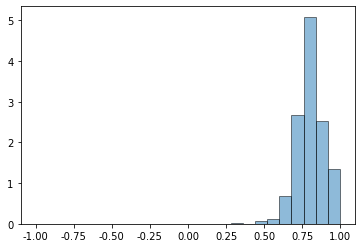

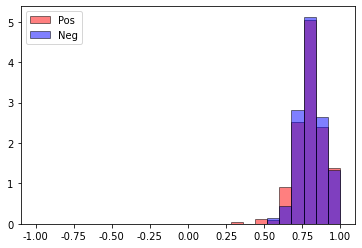

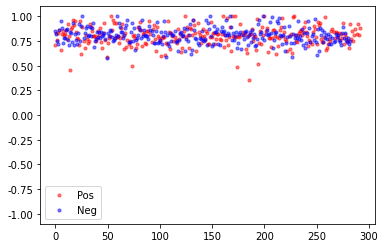

In [23]:
from model import FeatureErasureABS
FeatureErasureABS(model,test_batch,test_labels,'Softmax')

### Exp4--Attention Permutation

580it [00:25, 22.63it/s]


Both label
	total num: 580  mean: 0.15659924  std: 0.13357618
Pos
	total num: 293  mean: 0.14687517  std: 0.13226163
Neg
	total num: 287  mean: 0.16652662  std: 0.13418001


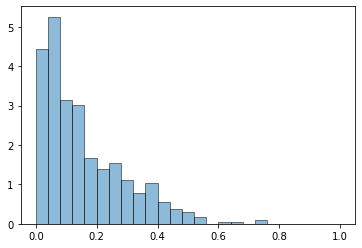

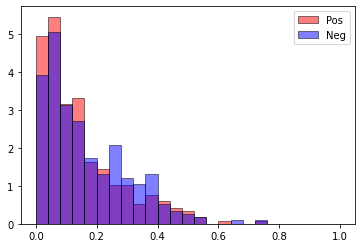

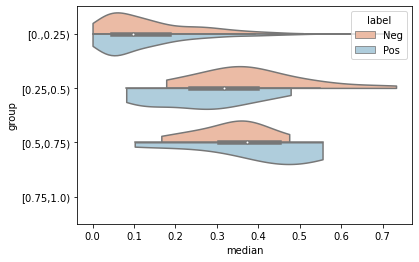

                 median                                                    \
                  count      mean       std       min       25%       50%   
label group                                                                 
Neg   [0.,0.25)   251.0  0.137839  0.109193  0.000000  0.052473  0.108250   
      [0.25,0.5)   26.0  0.379535  0.134343  0.177811  0.296705  0.365181   
      [0.5,0.75)   10.0  0.332774  0.089835  0.166040  0.274646  0.354218   
Pos   [0.,0.25)   258.0  0.126254  0.116610  0.000000  0.042422  0.086795   
      [0.25,0.5)   25.0  0.253202  0.119788  0.081306  0.134257  0.243215   
      [0.5,0.75)   10.0  0.413084  0.143541  0.101816  0.378721  0.442527   

                                      
                       75%       max  
label group                           
Neg   [0.,0.25)   0.204005  0.508194  
      [0.25,0.5)  0.433792  0.732633  
      [0.5,0.75)  0.373819  0.474730  
Pos   [0.,0.25)   0.164521  0.734715  
      [0.25,0.5)  0.326153  0.478

In [24]:
from model import AttnPermutation
AttnPermutation(model,test_batch,test_labels,'Softmax')

### Exp5--Attention Randomization

580it [00:32, 17.93it/s]


Both label
	total num: 580  mean: 0.2813022  std: 0.21381502
Pos
	total num: 293  mean: 0.27386546  std: 0.210358
Neg
	total num: 287  mean: 0.28889444  std: 0.21702483


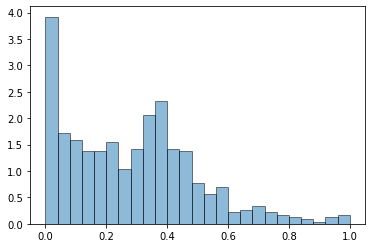

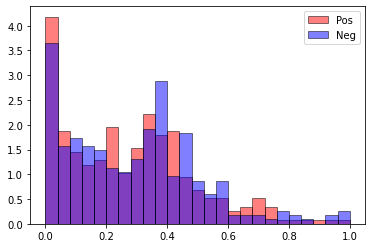

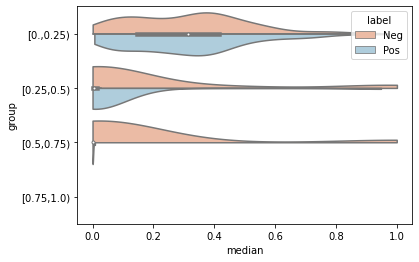

                 median                                                        \
                  count      mean       std           min       25%       50%   
label group                                                                     
Neg   [0.,0.25)   251.0  0.309032  0.192179  4.593052e-04  0.145509  0.320394   
      [0.25,0.5)   26.0  0.158335  0.321467  2.526327e-06  0.001677  0.005581   
      [0.5,0.75)   10.0  0.122908  0.312775  4.740335e-06  0.000009  0.000103   
Pos   [0.,0.25)   258.0  0.306092  0.195684  5.954504e-03  0.143197  0.293360   
      [0.25,0.5)   25.0  0.050394  0.189716  5.960464e-07  0.000616  0.002380   
      [0.5,0.75)   10.0  0.001100  0.002445  3.337860e-06  0.000006  0.000008   

                                      
                       75%       max  
label group                           
Neg   [0.,0.25)   0.434505  0.943719  
      [0.25,0.5)  0.091790  0.999956  
      [0.5,0.75)  0.042687  0.999306  
Pos   [0.,0.25)   0.410593  0.972450

In [25]:
from model import AttnRandom
AttnRandom(model,test_batch,test_labels,'Softmax')

### check selected tokens

In [29]:
pos_df = pd.DataFrame(zip(pos_index,pos_score),columns=['index','value'])
pos_top_index = pos_df.sort_values(by='value',ascending=False)['index'].values[:50]
pos_top_words = []
for item in pos_top_index:
    pos_top_words.append(idx2word[item])
print(pos_top_words)
print(len(pos_df))

['deal', 'played', 'own', 'exactly', 'p', 'taken', 'north', 'washington', 'station', 'pick', 'final', 'shots', 'tv', 'local', 'beat', 'during', 'canada', 'next', 'broadcast', 'pit', 'stars', 'check', 'german', 'stupid', 'late', 'show', 'period', 'group', 'speaking', 'put', 'canadian', 'roger', 'b', 'move', 'news', 'hard', 'points', 'area', 'results', 'vs', 'l', 'w']
42


In [30]:
neg_df = pd.DataFrame(zip(neg_index,neg_score),columns=['index','value'])
neg_top_index = neg_df.sort_values(by='value',ascending=True)['index'].values[:50]
neg_top_words = []
for item in neg_top_index:
    neg_top_words.append(idx2word[item])
print(neg_top_words)
print(len(neg_df))

['wears', 'passion', 'family', 'draws', 'slightly', 'trash', 'frank', 'semi', 'political', 'dog', 'plenty', 'push', 'important', 'working', 'talking', 'video', 'match', 'nearly', 'spectacular', 'christian', 'force', 'hip', 'complaint', 'brilliant', 'pot', 'artists', 'sides', 'development', 'letter', 'minor', 'seven', 'surprises', 'observations', 'build', 'missing', 'intelligence', 'suck', 'average', 'sharp', 'powers', 'thoughtful', 'mouth', 'baseball', 'ron', 'store', 'experience', 'meaning', 'barry', 'wise', 'painful']
134


In [31]:
neu_df = pd.DataFrame(zip(neutral_index,neutral_score),columns=['index','value'])
neu_top_index1 = neu_df.sort_values(by='value',ascending=True)['index'].values[:50]
neu_top_index2 = neu_df.sort_values(by='value',ascending=False)['index'].values[:50]
neu_top_words = []
for item in neu_top_index1:
    neu_top_words.append(idx2word[item])
for item in neu_top_index2:
    neu_top_words.append(idx2word[item])
print(neu_top_words)
print(len(neu_df))

['been', 'or', 'players', 'have', 'year', 'should', 'better', 't', 'names', 'your', 'even', 'people', 'fan', 'really', 'tell', 'very', 'someone', 'lost', 'heard', 'best', 'could', 'read', 'this', 'were', 'we', 'made', 'number', 'player', 'reading', 'oh', 'by', 'too', 'hoping', 'down', 'like', 'kind', 'true', 'credit', 'regardless', 'please', 'last', 'man', 'any', 'into', 'future', 'wants', 'nice', 'full', 'expect', 'standard', 'personal', 'thoughts', 'sports', 'leave', 'easily', 'seriously', 'early', 'likes', 'paid', 'daily', 'think', 'broken', 'serves', 'heart', 'scores', 'highly', 'mid', 'term', 'respond', 'unlike', 'selling', 'memorial', 'dear', 'despite', 'individual', 'shame', 'receiving', 'catching', 'strongest', 'winners', 'lot', 'need', 'create', 'indians', 'allen', 'behind', 'try', 'shut', 'trouble', 'reached', 'means', 'among', 'summer', 'pain', 'fighting', 'pa', 'trick', 'easy', 'clock', 'dry']
308
